In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import permutation as perm
%matplotlib inline

import keras.backend as K
from keras.datasets import cifar100 as c100
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
import yolo.config as cfg
from yolo.process import preprocess

Using TensorFlow backend.


In [2]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
print(K.image_data_format())
print(K.image_dim_ordering())
inp_w, inp_h, inp_c = cfg.inp_size
batch_size = cfg.batch_size
epochs = cfg.epochs

channels_last
tf


In [4]:
def prepare_output_data(y_train, y_test):
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    return y_train, y_test

In [5]:
def cifar_generator():
    """
    X_data : (data_size, 32, 32, 3)
    y_label : (data_size, 100)
    batch_size : batch size
    """
    (X_train, y_train), (X_test, y_test) = c100.load_data() # Load Data
    y_train, y_test = prepare_output_data(y_train, y_test) # prepare y_label 
    data_size = len(X_train)
    batch_iter_per_epoch = int(data_size/batch_size)
    while True:
        shuffle_idx = perm(np.arange(len(X_train)))
        print("*"*30)
        print("Data Size : {}".format(data_size))
        print("Batch Size : {}".format(batch_size))
        print("Batch iterations per Epoch : {}".format(batch_iter_per_epoch))
        print("*"*30)
        print(shuffle_idx[0:10])
        
        for b in range(batch_iter_per_epoch):
            batch_features = np.zeros((batch_size, inp_w, inp_h, inp_c))
            batch_labels = np.zeros((batch_size, 100))

            for b_i, i in enumerate(range(b*batch_size, b*batch_size + batch_size)):
                # choose random index in features
                batch_features[b_i] = preprocess(X_train[shuffle_idx[i]], color_type='RGB')
                batch_labels[b_i] = y_train[shuffle_idx[i]]
            yield batch_features, batch_labels
    
    print("Done Generator")

In [17]:
def make_model(is_freeze=False, activation_type='relu'):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(inp_w, inp_h, inp_c),padding='same', 
                            activation=activation_type, trainable=not is_freeze, name='conv1_1'))
    model.add(Conv2D(16, (3, 3), padding='same', 
                            activation=activation_type, trainable=not is_freeze, name='conv1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32,(3,3), padding='same', 
                            activation=activation_type, trainable=not is_freeze, name='conv2_1'))
    model.add(Conv2D(32,(3,3), padding='same', 
                            activation=activation_type, trainable=not is_freeze, name='conv2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

    model.add(Conv2D(64,(3,3), padding='same', 
                            activation=activation_type, trainable=not is_freeze, name='conv3_1'))
    model.add(Conv2D(64,(3,3), padding='same', 
                            activation=activation_type, trainable=not is_freeze, name='conv3_2'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
#     model.add(Conv2D(128,(3,3), padding='same', 
#                             activation=activation_type, trainable=not is_freeze, name='conv4'))
#     model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
#     model.add(Conv2D(256,(3,3), padding='same', 
#                             activation=activation_type, trainable=not is_freeze, name='conv5'))
#     model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
#     model.add(Conv2D(512,(3,3), padding='same', 
#                             activation=activation_type, trainable=not is_freeze, name='conv6'))
#     model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
#     model.add(Conv2D(1024,(3,3), padding='same', activation=activation_type, trainable=not is_freeze, name='conv7'))
#     model.add(Conv2D(1024,(3,3), padding='same', activation=activation_type, trainable=not is_freeze, name='conv8'))
#     model.add(Conv2D(1024,(3,3), padding='same', activation=activation_type, trainable=not is_freeze, name='conv9'))
    model.add(Flatten())
    model.add(Dense(256, name='dense1', activation=activation_type))
    model.add(Dense(512, name='dense2', activation=activation_type))
    model.add(Dense(100, name='softmax', activation='softmax'))
    
    return model

In [18]:
model = make_model(is_freeze=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 32, 32, 16)        448       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2_2 (Conv2D)             (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 8, 8, 64)          18496     
__________

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit_generator(cifar_generator(), 
                    steps_per_epoch=50000/batch_size, 
                    nb_epoch=50, 
                    verbose=1,
                    validation_data=None, 
                    class_weight=None,
                    workers=1)

C:\Users\Soma2\Anaconda3\envs\venvPython35\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=2, workers=1, class_weight=None, verbose=1, validation_data=None, steps_per_epoch=781.25)`


Epoch 1/2
******************************
Data Size : 50000
Batch Size : 64
Batch iterations per Epoch : 781
******************************
[18875 39562 46262 29366 21343 26563 28676 19110 44907 21022]
769/781 [============================>.] - ETA: 9s - loss: 4.2835 - acc: 0.0438         

KeyError: 'val_acc'

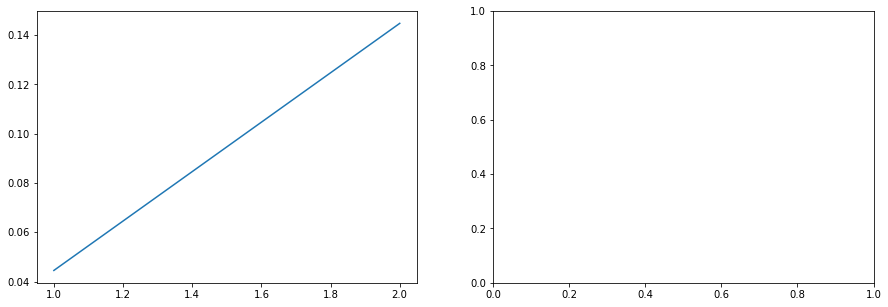

In [21]:
plot_model_history(history)

## Depregate

******************************
Data Size : 50000
Batch Size : 64
Batch iterations per Epoch : 781
******************************
[41366 19705 27126 16049 21231 17786 45037 44991 31991  4905]


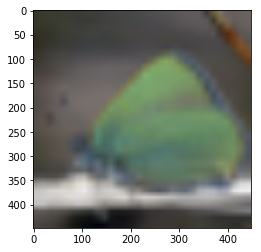

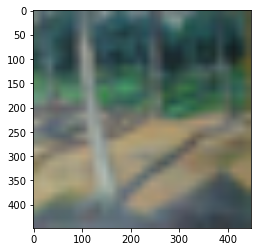

In [19]:
for i, (x_batch, y_batch) in enumerate(cifar_generator()):
    if i == 2:
        break
    plt.imshow(x_batch[0])
    plt.show()
#     if i % 100 == 0:
#         print("{} done..".format(i))